In [1]:
from plotnine import *
import pandas as pd

In [2]:
# prompt: loop through demo folder to get all the csv files, make 1 dataframe of all files. Also take the year from the file name (4 digits) and add it as a seperate column to the dataframe

import os
import glob

# Create an empty list to store the dataframes
df_list = []

# Get the current working directory
cwd = os.getcwd()
# print(cwd)

# Change directory to the demo folder
os.chdir(os.path.join(cwd, "data"))

# Get a list of all the csv files in the demo folder
csv_files = glob.glob("*.csv")

# Loop through the csv files and create a dataframe for each file
for file in csv_files:
    # Read the csv file into a dataframe
    df = pd.read_csv(file, delimiter=";")

    # Extract the year from the file name
    year = int(file[26:30])

    # Add the year as a separate column to the dataframe
    df["year"] = year

    # Append the dataframe to the list
    df_list.append(df)

# Concatenate all the dataframes in the list into a single dataframe
df = pd.concat(df_list)

# Change directory back to the original working directory
os.chdir(cwd)

# Print the dataframe
print(df)


1980
2050
1950
1990
2030
2040
2020
2010
2000
2060
2070
1960
1970
              Leeftijd   Mannen  Vrouwen  year
0    105 jaar of ouder      NaN      NaN  1980
1                  NaN        0        0  1980
2             104 jaar        0        0  1980
3             103 jaar        0        0  1980
4             102 jaar        0        0  1980
..                 ...      ...      ...   ...
102             4 jaar  124 000  117 000  1970
103             3 jaar  121 000  115 000  1970
104             2 jaar  121 000  115 000  1970
105             1 jaar  119 000  115 000  1970
106             0 jaar  125 000  119 000  1970

[1391 rows x 4 columns]


In [3]:
# prompt: Using dataframe df: take only the digits from the leeftijd column

df['Leeftijd'] = df['Leeftijd'].str.extract('(\d+)')

# Reset the index after dropping NaNs to avoid duplicate index values
df['Leeftijd'] = df['Leeftijd'].dropna().astype('int').reset_index(drop=True)

# Drop NaN values from the entire DataFrame
df = df.dropna()

df['Mannen'] = df['Mannen'].str.replace(' ', '').astype(int)
df['Vrouwen'] = df['Vrouwen'].str.replace(' ', '').astype(int)

bins = [0, 18, 65, 105]
labels = ['0-18', '18-65', '65+']

df['Leeftijdsgroep'] = pd.cut(df['Leeftijd'], bins, labels=labels)

df_grouped = df.groupby(['year', 'Leeftijdsgroep']).sum()

# prompt: add the aggregation logic 

df_grouped = df_grouped.groupby(['year', 'Leeftijdsgroep']).agg(
    total_men=pd.NamedAgg(column='Mannen', aggfunc='sum'),
    total_women=pd.NamedAgg(column='Vrouwen', aggfunc='sum')
).reset_index()


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
/var/folders/pb/dzrglzgn63v9lxr16885ybl80000gn/T/ipykernel_5979/31704611.py:3: SyntaxWarning: invalid escape sequence '\d'
/var/folders/pb/dzrglzgn63v9lxr16885ybl80000gn/T/ipykernel_5979/31704611.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/pb/dzrglzgn63v9lxr16885ybl80000gn/T/ipykernel_5979/31704611.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [4]:
df_grouped['total'] = df_grouped['total_men'] + df_grouped['total_women']

In [5]:
# prompt: make a column to df_grouped which indicates the grand percentage total per leeftijdsgroep per year

df_grouped['grand_total_men'] = df_grouped.groupby('year')['total_men'].transform(lambda x: 100 * x / x.sum())
df_grouped['grand_total_women'] = df_grouped.groupby('year')['total_women'].transform(lambda x: 100 * x / x.sum())
df_grouped['grand_total'] = df_grouped.groupby('year')['total'].transform(lambda x: 100 * x / x.sum())

In [8]:
df_grouped["year"] = df_grouped["year"].astype(int)



In [9]:
df_grouped_melt = df_grouped.melt(id_vars=["year", "Leeftijdsgroep"],
                                  value_vars=["grand_total_men", "grand_total_women"],
                                  var_name="gender",
                                  value_name="percentage")

# Replace 'total_men' and 'total_women' with 'men' and 'women' in the gender column
df_grouped_melt['gender'] = df_grouped_melt['gender'].replace({'grand_total_men': 'men', 'grand_total_women': 'women'})

/Users/bobdewitte/Documents/plotnine/plotnine/lib/python3.12/site-packages/plotnine/scales/scale_linetype.py:51: PlotnineWarning: Using linetype for an ordinal variable is not advised.
/Users/bobdewitte/Documents/plotnine/plotnine/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/bobdewitte/Documents/plotnine/plotnine/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/bobdewitte/Documents/plotnine/plotnine/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/bobdewitte/Documents/plotnine/plotnine/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/bobdewitte/Documents/plotnine/plotni

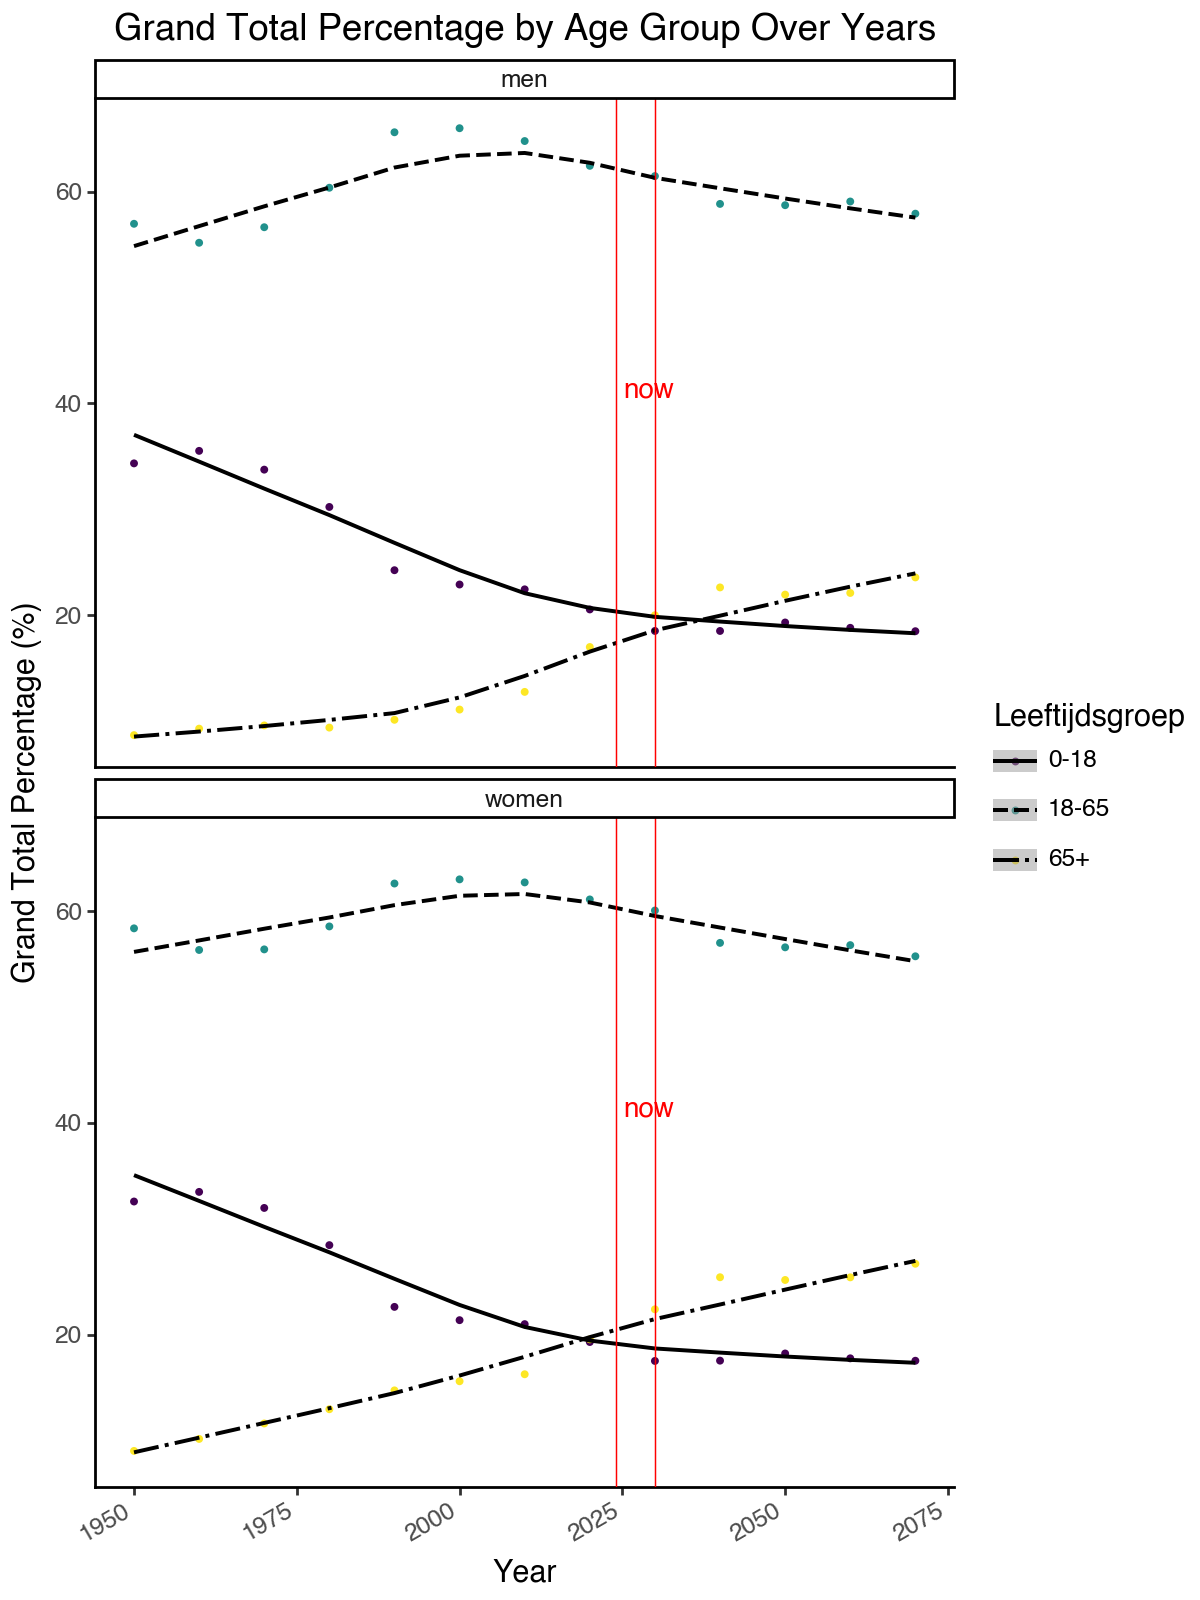

In [13]:
ggplot(data=df_grouped_melt) +\
geom_point(mapping=aes(x="year", y="percentage", color="Leeftijdsgroep"), size=0.6) +\
geom_smooth(mapping=aes(x="year", y="percentage", linetype="Leeftijdsgroep"), size=0.8, alpha=0.5) +\
geom_vline(xintercept=2024, linetype="solid", color="red", size=0.3) +\
geom_vline(xintercept=2030, linetype="solid", color="red", size=0.3) +\
facet_wrap("gender", nrow=2) +\
annotate("text", x=2025, y=40, label="now", color="red", ha='left', va='bottom', size=10, nudge_x=0.2) +\
    labs(
        title="Grand Total Percentage by Age Group Over Years",
        y="Grand Total Percentage (%)",
        x="Year"
    ) +\
    theme_classic() +\
    theme(axis_text_x=element_text(angle=30, hjust=1), figure_size=(6, 8))   

/Users/bobdewitte/Documents/plotnine/plotnine/lib/python3.12/site-packages/plotnine/scales/scale_linetype.py:51: PlotnineWarning: Using linetype for an ordinal variable is not advised.
/Users/bobdewitte/Documents/plotnine/plotnine/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/bobdewitte/Documents/plotnine/plotnine/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/bobdewitte/Documents/plotnine/plotnine/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/bobdewitte/Documents/plotnine/plotnine/lib/python3.12/site-packages/plotnine/stats/smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/bobdewitte/Documents/plotnine/plotni

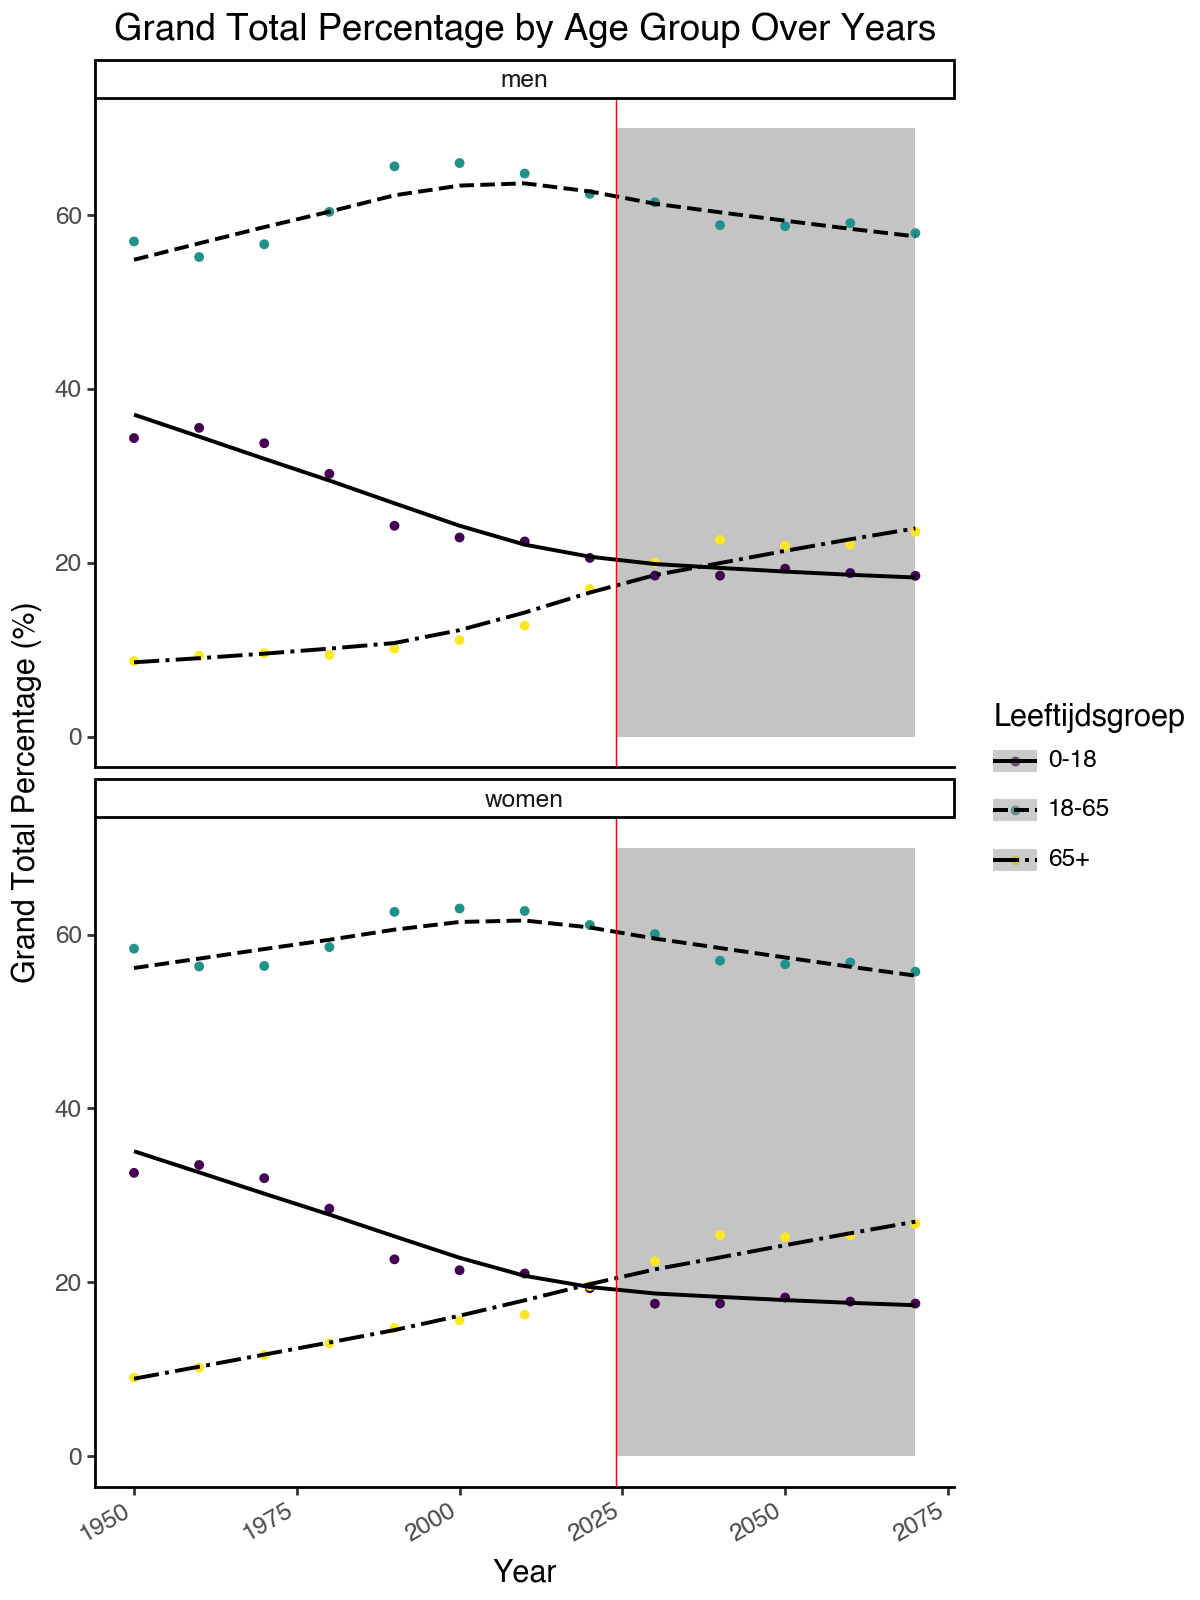

In [14]:
ggplot(data=df_grouped_melt) +\
geom_rect(aes(xmin=2024, xmax=max(df_grouped_melt['year']), ymin=0, ymax=70), fill='#595959', alpha=0.0059) +\
geom_point(mapping=aes(x="year", y="percentage", color="Leeftijdsgroep"), size=1) +\
geom_smooth(mapping=aes(x="year", y="percentage", linetype="Leeftijdsgroep"), size=0.8, alpha=0.5) +\
facet_wrap("gender", nrow=2) +\
geom_vline(xintercept=2024, linetype="solid", color="red", size=0.3) +\
    labs(
        title="Grand Total Percentage by Age Group Over Years",
        y="Grand Total Percentage (%)",
        x="Year"
    ) +\
    theme_classic() +\
    theme(axis_text_x=element_text(angle=30, hjust=1), figure_size=(6, 8)) +\
    ylim(0, 70)

# annotate("text", x=2025, y=40, label="now", color="red", ha='left', va='bottom', size=10, nudge_x=0.2) +\ 

In [15]:
# Using plotnine to create the plot
plot = (
    ggplot(df_grouped_melt, aes(x='year', y='percentage', color='gender', linetype='Leeftijdsgroep')) +
    geom_smooth(aes(group='interaction'), size=0.5) + # Use the new interaction column for grouping
    geom_point(aes(x=2019, y=19.5), color="black", size=2) +
    geom_point(aes(x=2037, y=19.5), color="black", size=2) +
    scale_color_manual(values={"men": "purple", "women": "red"}) +
        labs(
        title="Grand Total Percentage by Age Group Over Years",
        y="Grand Total Percentage (%)",
        x="Year"
    ) +\
    theme_minimal() +\
    theme(axis_text_x=element_text(angle=30, hjust=1), figure_size=(7, 5))
    # xlim(2000, 2050)
    # geom_vline(xintercept=2024, linetype="solid", color="red", size=0.3)
    
)


print(plot)

/var/folders/pb/dzrglzgn63v9lxr16885ybl80000gn/T/ipykernel_5979/90791018.py:21: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


PlotnineError: "Could not evaluate the 'group' mapping: 'interaction' (original error: name 'interaction' is not defined)"